In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datafile = "recorded_sensor_data/field_data_2/auto/mocap_data-175.173.csv"
reader = csv.reader(open(datafile, 'r'))

next(reader) # skip header
data = []
for row in reader:
    data.append(list(map(float, [row[0],row[1],row[2],row[5]])))
data = np.array(data)

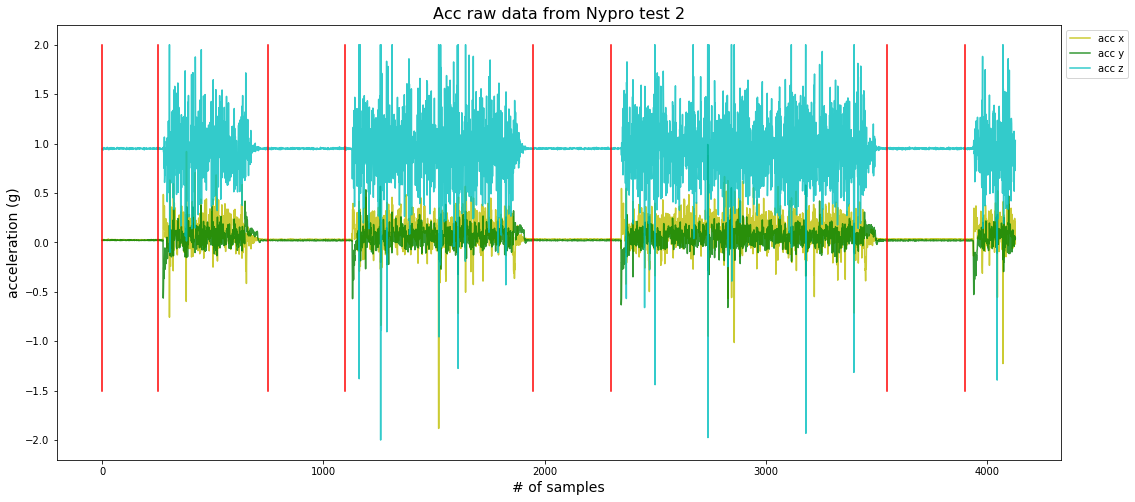

In [3]:
static_guess = [[0, 250],[750,1100],[1950,2300],[3550,3900]]

opacity = 0.8

plt.figure(figsize=(18,8))
plt.title("Acc raw data from Nypro test 2", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
plt.plot(data[:,0] , c = 'y', alpha = opacity, label = 'acc x')
plt.plot(data[:,1] , c = 'g', alpha = opacity, label = 'acc y')
plt.plot(data[:,2] , c = 'c', alpha = opacity, label = 'acc z')
for g in static_guess:
    plt.plot([g[0],g[0]],[-1.5,2.0], c = 'r')
    plt.plot([g[1],g[1]],[-1.5,2.0], c = 'r')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Diff btw final static mean and first static mean: [ 0.00610059 -0.00201186  0.00036681]


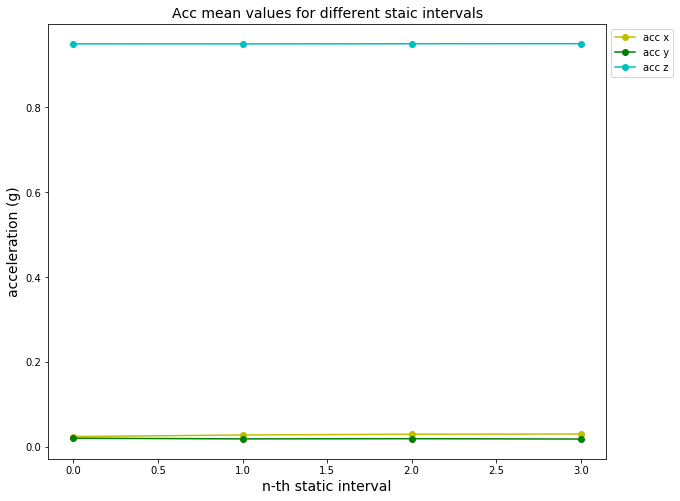

In [4]:
averages = []

for x in static_guess:
    averages.append(np.mean(data[x[0]: x[1],:], axis = 0))

averages = np.array(averages)    


print("Diff btw final static mean and first static mean:", (averages[3]-averages[0])[:3])

plt.figure(figsize=(10,8))
plt.title("Acc mean values for different staic intervals", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
plt.xlabel("n-th static interval", fontsize = 14)
plt.plot(averages[:,0], c = 'y',marker = 'o', label = "acc x")
plt.plot(averages[:,1], c = 'g', marker = 'o', label = "acc y")
plt.plot(averages[:,2], c = 'c', marker = 'o', label = "acc z")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [8]:
def clockwise_yaw_rotation_matrix(yaw_angle):
    # https://en.wikipedia.org/wiki/Rotation_matrix
    R = np.array([[np.cos(yaw_angle), np.sin(yaw_angle), 0],
                        [-np.sin(yaw_angle), np.cos(yaw_angle), 0],
                        [0, 0, 1]])
    return R

def integrate_sth(data, dt, convertion_factor):
    result = np.ndarray(data.shape)
    v_i = 0
    for i in range(len(data)):
        if i == 0:
            a = data[i] / 2
        else:  
            a = data[i] / 2 + data[i - 1] / 2
        v_f = a * dt * convertion_factor + v_i
        result[i] = v_f
        v_i = v_f
    return result


def integrate_velocity_with_yaw(data, dt, convertion_factor, yaws):
    result = np.ndarray(data.shape)
    v_i = 0
    for i in range(len(data)):
        if i == 0:
            a = data[i] / 2
        else:  
            a = data[i] / 2 + data[i - 1] / 2
        
        a = (clockwise_yaw_rotation_matrix(yaws[i] / 180 * np.pi) @ a.T).T
        v_f = a * dt * convertion_factor + v_i
        result[i] = v_f
        v_i = v_f
    return result

def calibrate(input_data):
    # Ideal accelerometer calibration parameters
    acc_calibration_params = np.array([2.29299485e-03, 9.73357832e-04, 2.18891523e-03,
                                       9.97372417e-01, 9.98078141e-01, 9.95206414e-01,
                                       -8.12765191e-03, -1.24052008e-02, -1.41327621e-02])
    # Ideal gyro calibration parameters
    gyro_calibration_params = np.array([0.00844165, 0.00196508, -0.00410652,
                                       -0.01548789, -0.00191488, -0.00770839,
                                       0.40658698, 0.40275294, 0.40165824])
    
    Ta = np.array([[1, -acc_calibration_params[0], acc_calibration_params[1]],
                   [0, 1, -acc_calibration_params[2]],
                   [0, 0, 1]])
    
    Tg = np.array([[1, -gyro_calibration_params[0], gyro_calibration_params[1]],
                   [gyro_calibration_params[2], 1, -gyro_calibration_params[3]],
                   [-gyro_calibration_params[4], gyro_calibration_params[5], 1]])
    
    Ka = np.array([[acc_calibration_params[3], 0, 0],
                   [0, acc_calibration_params[4], 0],
                   [0, 0, acc_calibration_params[5]]])
    
    Kg = np.array([[gyro_calibration_params[6], 0, 0],
                   [0, gyro_calibration_params[7], 0],
                   [0, 0, gyro_calibration_params[8]]])

    ba = acc_calibration_params[6:9]
#     ba = acc_bias
    bg = np.array([0.12964524, 0.15079131, 0.08211978])
    
    output_data = np.empty((input_data.shape[0], 6))
    output_data[:,0:3] = (Ta@Ka@(input_data[:,0:3] + ba).T).T
#     output_data[:,3:6] = (Tg@Kg@(input_data[:,3:6] + bg).T).T
    
    return output_data

def base_rotation(mean_acc_while_stationary):
    """ https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d """
    a = mean_acc_while_stationary
    b = np.array([0, 0, 1])
    v = np.cross(a, b)
    c = np.dot(a, b)
    v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = np.eye(3) + v_x + (v_x@v_x)*(1/(1+c))
    return R




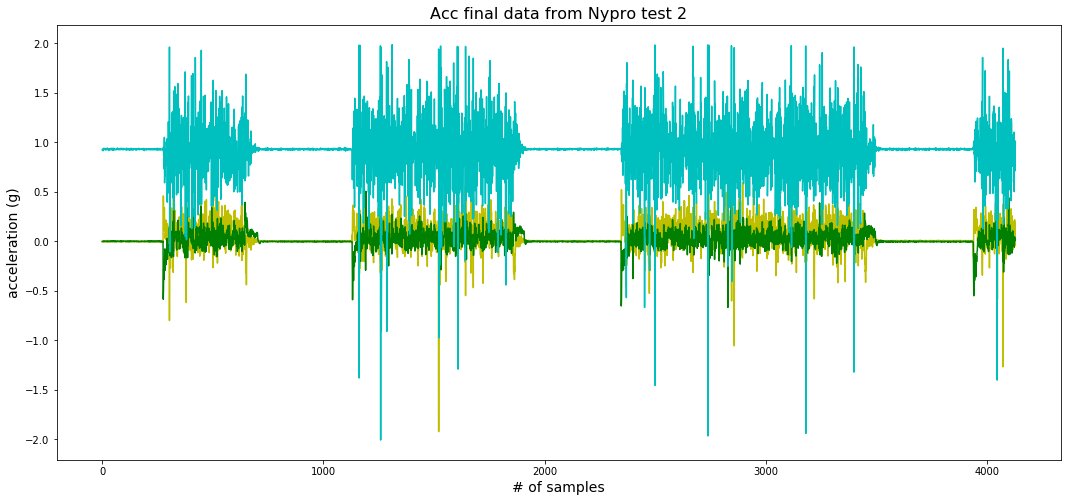

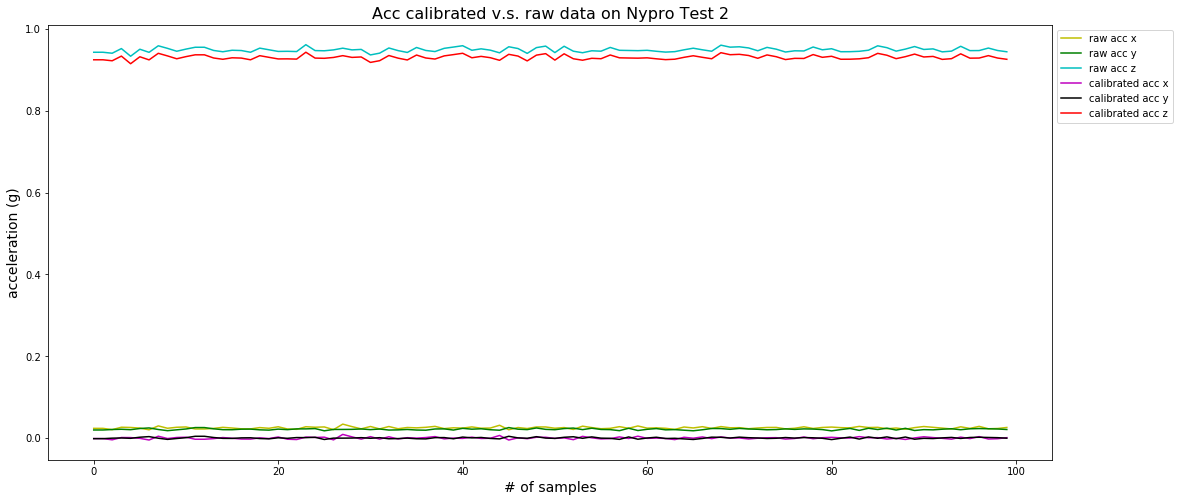

In [9]:
raw_acc_data = np.array(data[:,:3])

yaws = np.array(data[:,3])

calibrated_acc_data = calibrate(raw_acc_data)[:,:3]

calibrated_mean = np.mean(calibrated_acc_data[static_guess[0][0]:static_guess[0][1],:], axis = 0)

unit_calibrated_mean = calibrated_mean / np.linalg.norm(calibrated_mean)

R = base_rotation(unit_calibrated_mean)

final_acc_data = (R @ calibrated_acc_data.T).T


plt.figure(figsize=(18,8))
plt.title("Acc final data from Nypro test 2", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
plt.plot(final_acc_data[:,0] , c = 'y', label = 'acc x')
plt.plot(final_acc_data[:,1] , c = 'g', label = 'acc y')
plt.plot(final_acc_data[:,2] , c = 'c', label = 'acc z')
plt.show()



plt.figure(figsize=(18,8))
plt.title("Acc calibrated v.s. raw data on Nypro Test 2", fontsize = 16)
plt.xlabel("# of samples", fontsize = 14)
plt.ylabel("acceleration (g)", fontsize = 14)
plt.plot(data[:100,0] , c = 'y', label = 'raw acc x')
plt.plot(data[:100,1] , c = 'g', label = 'raw acc y')
plt.plot(data[:100,2] , c = 'c', label = 'raw acc z')
plt.plot(final_acc_data[:100,0] , c = 'm', label = 'calibrated acc x')
plt.plot(final_acc_data[:100,1] , c = 'k', label = 'calibrated acc y')
plt.plot(final_acc_data[:100,2] , c = 'r', label = 'calibrated acc z')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


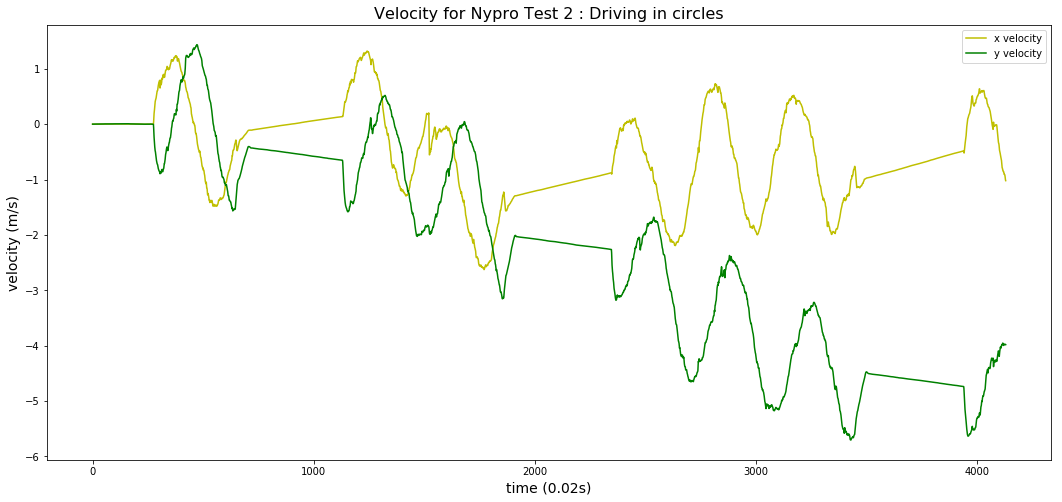

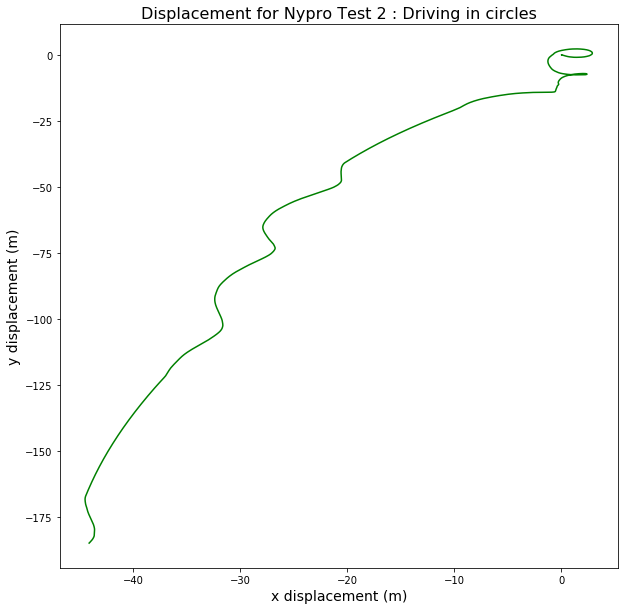

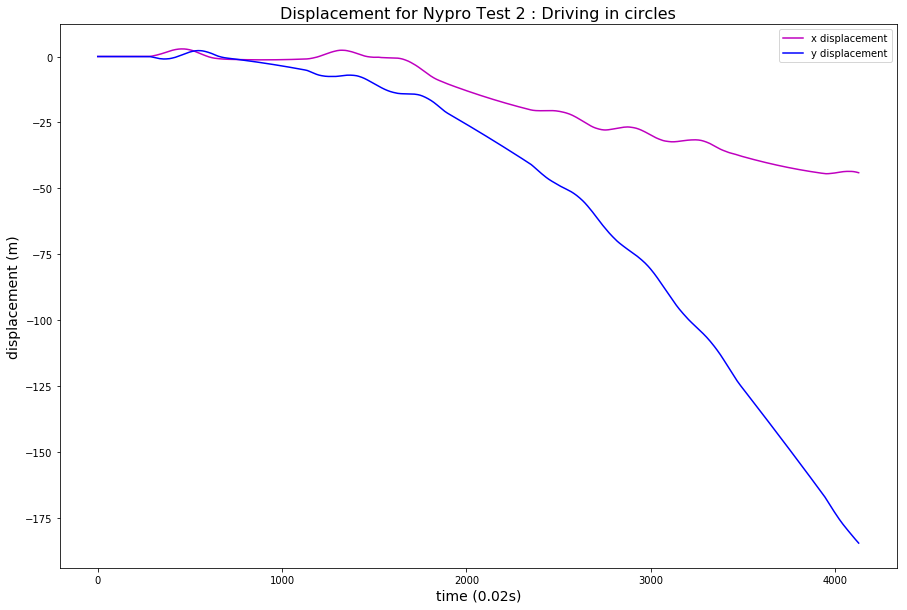

In [16]:
velocity = integrate_velocity_with_yaw(final_acc_data, 0.02, 9.8, yaws)

displacement = integrate_sth(velocity, 0.02, 1)

plt.figure(figsize=(18,8))
plt.title("Velocity for Nypro Test 2 : Driving in circles", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("velocity (m/s)", fontsize = 14)
plt.plot(velocity[:,0] , c = 'y', label = 'x velocity')
plt.plot(velocity[:,1] , c = 'g', label = 'y velocity')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.figure(figsize=(10,10))
plt.title("Displacement for Nypro Test 2 : Driving in circles", fontsize = 16)
plt.xlabel("x displacement (m)", fontsize = 14)
plt.ylabel("y displacement (m)", fontsize = 14)
plt.plot(displacement[:,0], displacement[:,1], c = 'g')
plt.show()


plt.figure(figsize=(15,10))
plt.title("Displacement for Nypro Test 2 : Driving in circles", fontsize = 16)
plt.xlabel("time (0.02s)", fontsize = 14)
plt.ylabel("displacement (m)", fontsize = 14)
plt.plot(displacement[:,0], c = 'm', label = 'x displacement')
plt.plot(displacement[:,1], c = 'b', label = 'y displacement')
plt.legend(bbox_to_anchor=(1,1))
plt.show()